<center><img src="logo.png" alt="AWS Logo" width="400" style="background-color:white; padding:1em;" /></center> <br/>

# Application of Deep Learning to Text and Image Data
## Module 1, Lab 4: Introducing CNNs

In the previous labs, you used neural networks to predict the target field of a given dataset. You used a feed-forward neural network for a multiclass classification task using images as inputs.

Now you will use a convolutional neural network (CNN) that is specialized to extract useful information from images. You will train and evaluate this network on a dataset of handwritten digits, and you will try to predict a number that is represented in an image.

You will learn how to do the following:

- Build a CNN.
- Train a CNN.
- Test the performance of a CNN.

---

You will be presented with two kinds of exercises throughout the notebook: activities and challenges. <br/>

| <img style="float: center;" src="images/activity.png" alt="Activity" width="125"/>| <img style="float: center;" src="images/challenge.png" alt="Challenge" width="125"/>|
| --- | --- |
|<p style="text-align:center;">No coding is needed for an activity. You try to understand a concept, <br/>answer questions, or run a code cell.</p> |<p style="text-align:center;">Challenges are where you can practice your coding skills.</p> |


---
## Index

* [MNIST dataset](#MNIST-dataset)
* [Creating a CNN](#Creating-a-CNN)
* [Training the network](#Training-the-network)
* [Testing the network](#Testing-the-network)

---
## MNIST dataset

The [MNIST dataset](http://yann.lecun.com/exdb/mnist) is a large collection of handwritten digits. Each example contains a pixel map showing how a person wrote a digit. The images have been size-normalized and centered with fixed dimensions. The labels correspond to the digit in the image, ranging from 0 to 9. This is a multiclass classification task with 10 output classes.

<img src="images/MnistExamples.png" alt="MNIST Examples" />

First, download the MNIST dataset.

In [1]:
%%capture
# Install libraries
!pip install -U -q -r requirements.txt

In [2]:
# Import the library dependencies
import boto3
import os
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.optim import SGD

Matplotlib is building the font cache; this may take a moment.


In [3]:
# Load the train data (it's included in the torchvision library)
train_data = torchvision.datasets.MNIST(
    root="data", train=True, transform=transforms.ToTensor(), download=True
)

# Load the test data (it's included in the torchvision library)
test_data = torchvision.datasets.MNIST(
    root="data", train=False, transform=transforms.ToTensor(), download=True
)

# Print the dimensions of the datasets
print(
    "Training data shape: {}. \nTest data shape: {}".format(
        list(train_data.data.shape), list(test_data.data.shape)
    )
)

100%|██████████| 9912422/9912422 [00:00<00:00, 145588001.74it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 75192857.74it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48880393.80it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11496999.86it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Training data shape: [60000, 28, 28]. 
Test data shape: [10000, 28, 28]


<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">To observe a sample image from the MNIST dataset, run the following cell. The image is labeled with the digit that is present in the sample image.</p>
    <br>
</div>

Text(0.5, 1.0, 'Image with target: 2')

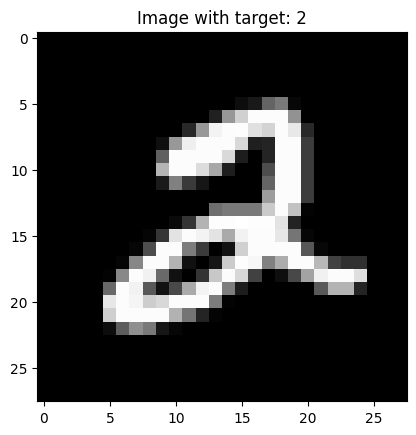

In [4]:
# Show an example image
plt.imshow(train_data.data[5], cmap="gray")
plt.title("Image with target: %i" % train_data.targets[5])

---
## Creating a CNN

Convolutional neural networks (CNNs) are popular with image data. The network automatically extracts useful features from images, such as edges, contours, and objects.

This lab introduces CNNs, but the details of CNNs will be discussed in a later module.

CNNs require minimal preprocessing compared to older algorithms, such as feed-forward neural networks, that are used for computer vision. Although feed-forward neural networks can still be used with image data, CNNs can capture the spatial and temporal properties in an image with a significant reduction in the number of parameters. In this notebook, you will use a simple CNN to extract information from image data.

You will use PyTorch's [Conv2D layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with the following interface to process the images:

`nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, ...) `

Parameter definitions:
* __in\_channels (int):__ Number of channels in the input image
* __out\_channels (int):__ Number of channels that are produced by the convolution
* __kernel\_size (int or tuple):__ Size of the convolving kernel
* __stride (int or tuple, optional):__ Stride of the convolution (default is 1)

The output dimension of the Conv2D layer can be calculated using the following formula:

`((W - K + 2P)/S + 1)`

Where:
- W = Input size
- K = Kernel size
- S = Stride
- P = Padding (not used in the notebook)

Example: 

For an `image of size = (28x28)`, `kernel size = 3` , `stride = 1`, and `padding = 0`, the output dimension is `(28 - 3 + 0)/1 + 1 = 26`. 

With `out_channels = 1`, the output dimension is `(26, 26)`.

With `out_channels = 3`, the output dimension is `(26, 26, 3)`.

In [6]:
# Define hyperparameters
batch_size = 100  # Size of input data for one iteration
num_classes = 10  # Number of output classes, discrete range [0,9]
num_epochs = (
    10  # Number of times that the entire dataset is passed through the model
)

# Learning Rate
lr = 1e-3

# Use GPU if available; otherwise, use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Use PyTorch DataLoaders to load the data in batches
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True
)

# Repeat for test dataset
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=batch_size, shuffle=False
)

<div style="border: 4px solid coral; text-align: center; margin: auto;"> 
  <h3><i>Try it yourself!</i></h3>
  <p style="text-align:center; margin:auto;"><img src="images/challenge.png" alt="Challenge" width="100" /> </p>
  <p style=" text-align: center; ">Create a neural network with a 2D convolutional layer and the following attributes:</p>
  <div style="width:600px; margin: 0 auto;">
    <ul style="text-align:left">
    <li>Conv2D layer with <code>in_channel=1</code>, <code>out_channel=32</code>, and <code>kernel_size=3</code></li>
    <li>Flatten the layer to squash the data into a one-dimensional tensor</li>
    <li>Linear layer with 128 units</li>
    <li>One output layer</li>
    <li>Softmax activation function for the output layer</li>
    </ul>
  </div>
</div>

In [8]:
input_size = 26 * 26 * 32  # Flattened dimension for the linear layer

############### CODE HERE ###############

import torch.nn.functional as F

net = nn.Sequential(
    nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3),     # Layer 1
    nn.ReLU(),
    nn.Flatten(start_dim = 1),    # squash to 1d tensor
    nn.Linear(input_size, 128),  # Linear layer with 128 units
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Output layer 10 units
    nn.Softmax(dim=1)  # Softmax activation function for the output layer
).to(device)

############## END OF CODE ##############

def xavier_init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

# Initialize weights/parameters for the network
net.apply(xavier_init_weights)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=21632, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
  (6): Softmax(dim=1)
)

In [9]:
# Define the loss function and the optimizer

# Choose cross-entropy loss for this classification problem
loss = nn.CrossEntropyLoss()

# Choose the Adam optimizer. You can also experiment with other optimizers.
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

---
## Training the network

Now you are ready to train the CNN.

In [10]:
import time

# Network training and validation

# Start the outer epoch loop (epoch = full pass through the dataset)
for epoch in range(num_epochs):
    start = time.time()

    training_loss = 0.0

    # Training loop (with autograd and trainer steps)
    # This loop trains the neural network
    # Weights are updated here
    net.train()  # Activate training mode (dropouts and so on)
    for images, target in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        images = images.to(device)
        target = target.to(device)
        # Forward + backward + optimize
        output = net(images)
        L = loss(output, target)
        L.backward()
        optimizer.step()
        # Add batch loss
        training_loss += L.item()

    # Take the average losses
    training_loss = training_loss / len(train_loader)

    end = time.time()
    print("Epoch %s. Train_loss %f Seconds %f" % (epoch, training_loss, end - start))

Epoch 0. Train_loss 1.675306 Seconds 29.086082
Epoch 1. Train_loss 1.580601 Seconds 6.397759
Epoch 2. Train_loss 1.543787 Seconds 6.449526
Epoch 3. Train_loss 1.480026 Seconds 6.543799
Epoch 4. Train_loss 1.474473 Seconds 6.390218
Epoch 5. Train_loss 1.471681 Seconds 6.397176
Epoch 6. Train_loss 1.470210 Seconds 6.383377
Epoch 7. Train_loss 1.468701 Seconds 6.370008
Epoch 8. Train_loss 1.467971 Seconds 6.379450
Epoch 9. Train_loss 1.466843 Seconds 6.379603


---
## Testing the network

Finally, evaluate the performance of the trained network on the test set.

In [11]:
from sklearn.metrics import classification_report

net.eval()  # Activate eval mode (don't use dropouts and such)

# Get test predictions
predictions, labels = [], []
for images, target in test_loader:
    images = images.to(device)
    target = target.to(device)

    predictions.extend(net(images).argmax(axis=1).tolist())
    labels.extend(target.tolist())

# Print performance on the test data
print(classification_report(labels, predictions, zero_division=1))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.96      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.96      0.98      0.97       974
           9       0.99      0.96      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



----
## Conclusion

In this notebook, you practiced using a CNN. 

--- 
## Next Lab: Processing text
In the next lab you will learn how to do more advanced text processing.